In [1]:
#import packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

['test.csv', 'FI.png', 'train.csv', 'sample_submission.csv']


/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#import data
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
#feature columns
features = [i for i in df_train.columns.values if i not in ['ID_code', 'target']]

In [12]:
#split training data
df0 = df_train[df_train['target'] == 0]
df1 = df_train[df_train['target'] == 1]

In [27]:
#summarize data distribution
df0_metrics = df0[features].describe()
df0_metrics.loc['Skew'] = df0[features].skew().values
df0_metrics.loc['Kurt'] = df0[features].kurt().values

df1_metrics = df1[features].describe()
df1_metrics.loc['Skew'] = df1[features].skew().values
df1_metrics.loc['Kurt'] = df1[features].kurt().values

In [28]:
#output
df0_metrics.T.to_csv('../tmp/df0_metrics.csv')
df1_metrics.T.to_csv('../tmp/df1_metrics.csv')

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


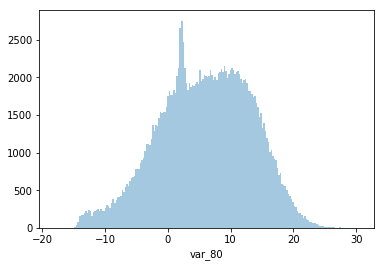

In [35]:
sns.distplot(df0['var_80'], kde=False, rug=False, bins=200) 

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


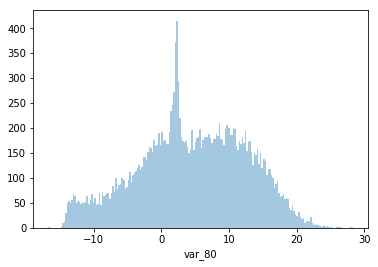

In [36]:
sns.distplot(df1['var_80'], kde=False, rug=False, bins=200) 

In [37]:
df_train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [49]:
df_metrics = df_train.describe()

In [58]:
type(df_metrics)

pandas.core.frame.DataFrame

In [64]:
df_metrics

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [65]:
df_metrics.loc['25%']

target      0.000000
var_0       8.453850
var_1      -4.740025
var_2       8.722475
var_3       5.254075
var_4       9.883175
var_5     -11.200350
var_6       4.767700
var_7      13.943800
var_8      -2.317800
var_9       6.618800
var_10     -3.594950
var_11     -7.510600
var_12     13.894000
var_13      5.072800
var_14      5.781875
var_15     14.262800
var_16      7.452275
var_17    -10.476225
var_18      9.177950
var_19      6.276475
var_20      8.627800
var_21     11.551000
var_22      2.182400
var_23      2.634100
var_24      7.613000
var_25     13.456400
var_26     -8.321725
var_27     -2.307900
var_28      4.992100
             ...    
var_170    -3.258500
var_171    -4.720350
var_172    13.731775
var_173    -5.009525
var_174    15.064600
var_175     9.371600
var_176    -8.386500
var_177     9.808675
var_178    -7.395700
var_179     0.625575
var_180    -6.673900
var_181     9.084700
var_182    -6.064425
var_183     5.423100
var_184     5.663300
var_185    -7.360000
var_186     6

In [67]:
df_1_4 = df_metrics.loc['25%']

In [72]:
type(df_1_4)

pandas.core.series.Series

In [73]:
df_1_4 = df_metrics.loc['25%'] #Series
df_3_4 = df_metrics.loc['75%'] #Series

In [75]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [77]:
df_1_4 = df_1_4[1:] #delete target
df_3_4 = df_3_4[1:] #delete target

In [99]:
df_1_4

var_0       8.453850
var_1      -4.740025
var_2       8.722475
var_3       5.254075
var_4       9.883175
var_5     -11.200350
var_6       4.767700
var_7      13.943800
var_8      -2.317800
var_9       6.618800
var_10     -3.594950
var_11     -7.510600
var_12     13.894000
var_13      5.072800
var_14      5.781875
var_15     14.262800
var_16      7.452275
var_17    -10.476225
var_18      9.177950
var_19      6.276475
var_20      8.627800
var_21     11.551000
var_22      2.182400
var_23      2.634100
var_24      7.613000
var_25     13.456400
var_26     -8.321725
var_27     -2.307900
var_28      4.992100
var_29      3.171700
             ...    
var_170    -3.258500
var_171    -4.720350
var_172    13.731775
var_173    -5.009525
var_174    15.064600
var_175     9.371600
var_176    -8.386500
var_177     9.808675
var_178    -7.395700
var_179     0.625575
var_180    -6.673900
var_181     9.084700
var_182    -6.064425
var_183     5.423100
var_184     5.663300
var_185    -7.360000
var_186     6

In [96]:
df_1_4.values - df_train[features].iloc[1,:].values

array([-3.0467500e+00, -5.9272500e-01, -5.1363250e+00, -1.3492500e-01,
       -2.4790250e+00, -1.8243650e+01, -8.5310000e-01, -2.5900000e+00,
       -5.4646000e+00, -1.4663000e+00, -3.1917500e+00, -1.5569100e+01,
       -1.2990000e-01, -3.3407000e+00,  3.4737500e-01,  5.6250000e-01,
       -6.3752250e+00,  5.1086750e+00,  1.3779500e+00, -2.2294325e+01,
        5.1991000e+00,  8.8103000e+00, -6.3700000e+00, -7.3750000e-01,
        6.3510000e-01, -4.3460000e-01,  3.4466750e+00,  2.5070000e-01,
       -5.4300000e-02,  2.6236000e+00, -4.4674750e+00,  9.9450000e-01,
       -3.7867750e+00, -7.9147000e+00, -3.3790000e-01, -6.2292500e-01,
       -2.8066250e+00, -1.7179250e+00, -3.2249500e+00, -5.8778000e+00,
       -1.7171250e+00,  2.6465750e+00,  8.3570000e-01, -4.4040000e-01,
        4.0692500e+00,  1.8649000e+01,  1.8769500e+00, -2.0849325e+01,
       -2.8049425e+01, -1.5050225e+01,  4.3470000e-01, -5.9579750e+00,
       -1.9567250e+00, -1.2529000e+00,  2.9469750e+00, -1.0435600e+01,
      

In [97]:
df_1_4.values - df_train[features].values

array([[-4.7165000e-01,  2.0462750e+00, -3.1856250e+00, ...,
        -3.1070000e-01,  1.0494000e+00, -1.0117075e+01],
       [-3.0467500e+00, -5.9272500e-01, -5.1363250e+00, ...,
        -5.3610000e-01, -4.5263000e+00, -1.3160275e+01],
       [-1.5545000e-01, -1.9943250e+00, -3.3580250e+00, ...,
        -1.4700000e-02, -8.9250000e-01, -1.1604975e+01],
       ...,
       [-2.7693500e+00,  3.1177500e-01, -1.7902250e+00, ...,
        -4.6270000e-01, -3.2000000e-03, -1.5407975e+01],
       [-1.2609500e+00,  3.8697750e+00, -4.8879250e+00, ...,
        -1.7814000e+00, -1.6992000e+00,  2.6916250e+00],
       [-2.4223500e+00,  9.7047500e-01, -3.3958250e+00, ...,
         6.7100000e-02,  1.7013000e+00, -1.1346975e+01]])

In [101]:
pd.DataFrame(df_1_4.values > df_train[features].values)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,False,True,False,True,False,False,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,True,True,False,False,True,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,True,False,False,False,False
5,False,False,False,False,False,False,True,False,False,True,...,True,False,False,True,True,False,True,False,True,False
6,False,False,False,True,False,False,False,True,True,False,...,False,False,False,True,False,False,False,False,True,False
7,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8,False,False,False,False,True,False,True,True,True,False,...,False,False,False,False,True,True,False,True,False,False
9,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False


In [102]:
pd.DataFrame(df_3_4.values < df_train[features].values)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,False,False,True,False,True,True,False,False,True,False,...,True,False,False,True,False,True,True,False,True,False
2,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,True,True,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
4,False,False,True,False,True,True,False,True,True,False,...,False,True,False,True,False,False,False,False,False,False
5,False,False,True,True,False,True,False,False,True,False,...,False,False,True,False,False,True,False,True,False,False
6,False,False,False,False,False,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
7,True,False,True,False,False,False,False,True,True,False,...,True,False,True,False,True,False,False,False,False,False
8,True,True,True,False,False,True,False,False,False,True,...,False,True,False,False,False,False,False,False,True,True
9,False,True,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [104]:
q1_columns = [i + '_q1' for i in features]

In [105]:
q1_columns

['var_0_q1',
 'var_1_q1',
 'var_2_q1',
 'var_3_q1',
 'var_4_q1',
 'var_5_q1',
 'var_6_q1',
 'var_7_q1',
 'var_8_q1',
 'var_9_q1',
 'var_10_q1',
 'var_11_q1',
 'var_12_q1',
 'var_13_q1',
 'var_14_q1',
 'var_15_q1',
 'var_16_q1',
 'var_17_q1',
 'var_18_q1',
 'var_19_q1',
 'var_20_q1',
 'var_21_q1',
 'var_22_q1',
 'var_23_q1',
 'var_24_q1',
 'var_25_q1',
 'var_26_q1',
 'var_27_q1',
 'var_28_q1',
 'var_29_q1',
 'var_30_q1',
 'var_31_q1',
 'var_32_q1',
 'var_33_q1',
 'var_34_q1',
 'var_35_q1',
 'var_36_q1',
 'var_37_q1',
 'var_38_q1',
 'var_39_q1',
 'var_40_q1',
 'var_41_q1',
 'var_42_q1',
 'var_43_q1',
 'var_44_q1',
 'var_45_q1',
 'var_46_q1',
 'var_47_q1',
 'var_48_q1',
 'var_49_q1',
 'var_50_q1',
 'var_51_q1',
 'var_52_q1',
 'var_53_q1',
 'var_54_q1',
 'var_55_q1',
 'var_56_q1',
 'var_57_q1',
 'var_58_q1',
 'var_59_q1',
 'var_60_q1',
 'var_61_q1',
 'var_62_q1',
 'var_63_q1',
 'var_64_q1',
 'var_65_q1',
 'var_66_q1',
 'var_67_q1',
 'var_68_q1',
 'var_69_q1',
 'var_70_q1',
 'var_71_q1',
 '

In [106]:
q1_columns = [i + '_q1' for i in features]
q3_columns = [i + '_q3' for i in features]

In [107]:
pd.DataFrame(df_1_4.values > df_train[features].values, columns=q1_columns)

,var_0_q1,var_1_q1,var_2_q1,var_3_q1,var_4_q1,var_5_q1,var_6_q1,var_7_q1,var_8_q1,var_9_q1,...,var_190_q1,var_191_q1,var_192_q1,var_193_q1,var_194_q1,var_195_q1,var_196_q1,var_197_q1,var_198_q1,var_199_q1
0,False,True,False,True,False,False,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,True,True,False,False,True,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,True,False,False,False,False
5,False,False,False,False,False,False,True,False,False,True,...,True,False,False,True,True,False,True,False,True,False
6,False,False,False,True,False,False,False,True,True,False,...,False,False,False,True,False,False,False,False,True,False
7,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8,False,False,False,False,True,False,True,True,True,False,...,False,False,False,False,True,True,False,True,False,False
9,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False


In [108]:
pd.DataFrame(df_1_4.values > df_train[features].values, columns=q1_columns) * 1 #convert True/False to 1/0

,var_0_q1,var_1_q1,var_2_q1,var_3_q1,var_4_q1,var_5_q1,var_6_q1,var_7_q1,var_8_q1,var_9_q1,...,var_190_q1,var_191_q1,var_192_q1,var_193_q1,var_194_q1,var_195_q1,var_196_q1,var_197_q1,var_198_q1,var_199_q1
0,0,1,0,1,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,1,0,0,0,0
5,0,0,0,0,0,0,1,0,0,1,...,1,0,0,1,1,0,1,0,1,0
6,0,0,0,1,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
7,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,1,0,1,1,1,0,...,0,0,0,0,1,1,0,1,0,0
9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [110]:
#if value is smaller than 25%, return True
q1 = pd.DataFrame(df_1_4.values > df_train[features].values, columns=q1_columns) * 1 #convert True/False to 1/0

#if value is larger than 75%, return True
q3 = pd.DataFrame(df_3_4.values < df_train[features].values, columns=q3_columns) * 1 #convert True/False to 1/0

In [111]:
q1

,var_0_q1,var_1_q1,var_2_q1,var_3_q1,var_4_q1,var_5_q1,var_6_q1,var_7_q1,var_8_q1,var_9_q1,...,var_190_q1,var_191_q1,var_192_q1,var_193_q1,var_194_q1,var_195_q1,var_196_q1,var_197_q1,var_198_q1,var_199_q1
0,0,1,0,1,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,1,0,0,0,0
5,0,0,0,0,0,0,1,0,0,1,...,1,0,0,1,1,0,1,0,1,0
6,0,0,0,1,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
7,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,1,0,1,1,1,0,...,0,0,0,0,1,1,0,1,0,0
9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [112]:
q3

,var_0_q3,var_1_q3,var_2_q3,var_3_q3,var_4_q3,var_5_q3,var_6_q3,var_7_q3,var_8_q3,var_9_q3,...,var_190_q3,var_191_q3,var_192_q3,var_193_q3,var_194_q3,var_195_q3,var_196_q3,var_197_q3,var_198_q3,var_199_q3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,1,0,1,1,0,0,1,0,...,1,0,0,1,0,1,1,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,0,1,0,1,1,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0
5,0,0,1,1,0,1,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
6,0,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
7,1,0,1,0,0,0,0,1,1,0,...,1,0,1,0,1,0,0,0,0,0
8,1,1,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,1
9,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [114]:
pd.concat([df_train, q1, q3], axis=1)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190_q3,var_191_q3,var_192_q3,var_193_q3,var_194_q3,var_195_q3,var_196_q3,var_197_q3,var_198_q3,var_199_q3
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,0,0,1,0,0,0,1,0,0,0
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,1,0,0,1,0,1,1,0,1,0
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,0,1,0,0,1,1,0,0,0,0
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,0,0,0,0,1,0,0,1,0,0
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,0,1,0,1,0,0,0,0,0,0
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,0,0,1,0,0,1,0,1,0,0
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,1,0,1,0,0,0,1,0,0,0
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,1,0,1,0,1,0,0,0,0,0
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,0,1,0,0,0,0,0,0,1,1
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0,0,0,0,0,0,1,0,0,1
